## Import and directories

In [2]:
#directories
import os
try:
    parentdir
except NameError:
    parentdir=os.getcwd()
else:
    parentdir = parentdir
# homedir=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655';#data directory
print('The working directory is parentdir: %s' %parentdir)
# print('The data directory is homedir: %s' %homedir)
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

The working directory is parentdir: /home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/Azurin_SM_repo/Manuscript/Figure


In [3]:
#Run this once to run the .py(Analysis_bis.py) file.
os.chdir(r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/Azurin_SM_repo/Analysis')
!python Analysis_bis.py
%run Analysis_bis.py

## Setup Schematic: Figure_1

## Time trace: Figure_2

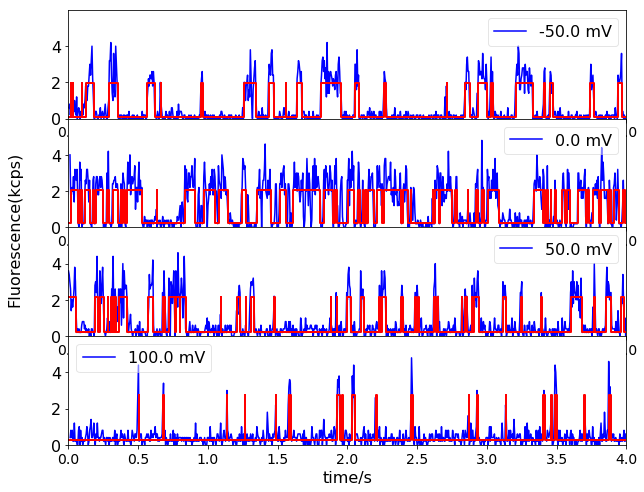

In [44]:
folder=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/30sec_trace'
fig = time_trace_plot(foldername= folder, input_potential=[-50, 0, 50, 100], pointnumbers=[1], x_lim_min=0, y_lim_min=0, x_lim_max=4, y_lim_max=6, bin=5, show_changepoint=True)
os.chdir(parentdir)
savefig('FigPart_2_timetrace.pdf', dpi=300, transparent=True)

## Toff/Ton plot_Nernst fit: Figure_3a

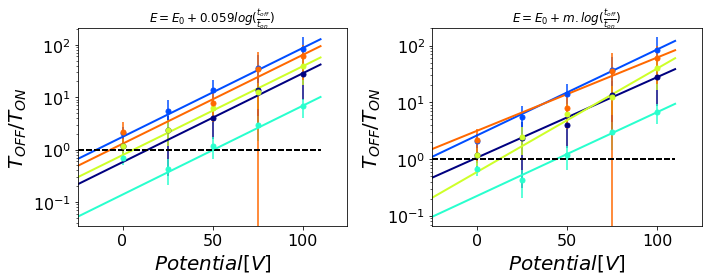

In [12]:
def Mid_potentials_slopem(folderpath=foldername, pointnumbers=range(20), plotting=True, min_pot=40, min_pot_num=1):
    timetrace_output = timetrace_outputs_folderwise(folderpath=folderpath, pointnumbers=pointnumbers, potentialist=potentialist)
    def nernst(x, a):
        '''x is potential
        a: E0/midpoint potential(parameter)
        returns ratio(t_oxd/t_red)'''
        return(10**((x - a) / 0.059))
    def nernst_slopem(x, a, m):
        return(10**((x - a) / m))
    columns_E0 = ['Point number', 'E0_fit', 'E0_err']
    columns_E0_m = ['Point number', 'E0_fit', 'E0_err', 'slope', 'slope_error']
    E0_list = pd.DataFrame(index=None, columns=columns_E0)
    E0_m_list = pd.DataFrame(index=None, columns=columns_E0_m)
    #--figure initiation----
    if plotting == True:
        fig, axes = plt.subplots(1, 2, figsize=(10,4))
        cmap = plt.get_cmap('jet')#jet_r
        N=len(timetrace_output.columns.levels[0])
    for i in range(len(timetrace_output.columns.levels[0])):
        point = timetrace_output.columns.levels[0][i]
        point_output_tot = timetrace_output[point].dropna()
        point_output = point_output_tot[point_output_tot['Potential'] >= min_pot] #select a potential threshold
        if len(point_output) > min_pot_num:
            potential = point_output['Potential']
            t_onav = point_output['t_onav']
            t_onaverr = point_output['t_onaverr']
            t_offav = point_output['t_offav']
            t_offaverr = point_output['t_offaverr']
            t_ratio = point_output['t_ratio']
            t_ratioerr = point_output['t_ratioerr']
            E = potential*0.001 #converting to mV
            #--------fitting nernst----------------
            E0_fit, E0_var = curve_fit(nernst, E, t_ratio, p0=0.02)
            E0_err = np.sqrt(np.diag(E0_var));
            E0 = E0_fit[0]; E0_err=E0_err[0]
            #---------append to list---------
            E0_list_temp = pd.DataFrame([[point, E0, E0_err]], columns=columns_E0)
            E0_list=E0_list.append(E0_list_temp, ignore_index=True)
            #--------fitting nernst_slopem------
            E0_m_fit, E0_m_var = curve_fit(nernst_slopem, E, t_ratio, p0=[0.02, 0.059])
            E0_m_err = np.sqrt(np.diag(E0_m_var))
            E0_m = E0_m_fit[0];E0_m_fit_err = E0_m_err[0];
            slope_m = E0_m_fit[1]; slope_m_err = E0_m_err[1];
            E0_m_list_temp = pd.DataFrame([[point, E0_m, E0_m_fit_err, slope_m, slope_m_err]], columns=columns_E0_m)
            E0_m_list = E0_m_list.append(E0_m_list_temp, ignore_index=True)
            #-----plot------
            if plotting == True:
                color = cmap(float(i)/N)
                axes[0].errorbar(point_output_tot['Potential'], point_output_tot['t_ratio'],
                         yerr=point_output_tot['t_ratioerr'], fmt='o', color=color, label=point, ms=5)#plot raw outputs
                axes[0].plot(linspace(-25, max(potential)+10), nernst(0.001*linspace(-25, max(potential)+10), *E0_fit), color=color, linewidth=2)#color
                axes[0].plot(linspace(-25, max(potential)+10), ones(len(linspace(-25, max(potential)+10))), '--k', linewidth=2)
                #plot(E*1000, nernst(E, *E0_fit), color=color, linewidth=2.0)

                
                axes[1].errorbar(point_output_tot['Potential'], point_output_tot['t_ratio'],
                         yerr=point_output_tot['t_ratioerr'], fmt='o', color=color, label=point, ms=5)#plot raw outputs
                axes[1].plot(linspace(-25, max(potential)+10), nernst_slopem(0.001*linspace(-25, max(potential)+10), *E0_m_fit), color=color, linewidth=2)
                axes[1].plot(linspace(-25, max(potential)+10), ones(len(linspace(-25, max(potential)+10))), '--k', linewidth=2)
                
                axes[0].set_yscale('log')
                axes[0].set_xlim(-25, 125)
                axes[0].set_xlabel('$Potential [V]$', fontsize=20)
                axes[0].set_ylabel('$T_{OFF}/T_{ON}$', fontsize=20)
                axes[0].tick_params(axis='both', which='major', labelsize=16)
                axes[0].set_title(r'$E=E_0 + 0.059log(\frac{t_{off}}{t_{on}})$')
                
                axes[1].set_yscale('log')
                axes[1].set_xlabel('$Potential [V]$', fontsize=20)
                axes[1].set_ylabel('$T_{OFF}/T_{ON}$', fontsize=20)
                axes[1].tick_params(axis='both', which='major', labelsize=16)
                axes[1].set_title(r'$E=E_0 + m.log(\frac{t_{off}}{t_{on}})$')
                axes[1].set_xlim(-25, 125)
                
                tight_layout()
                #legend(bbox_to_anchor=(0.9, 0.3), fontsize=16)
    return(E0_list, E0_m_list)
folder=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/30sec_trace'
E0_list, E0_m_list = Mid_potentials_slopem(folderpath=folder, pointnumbers=[3, 4, 10, 14, 16], plotting=True, min_pot=25, min_pot_num=1)
os.chdir(parentdir)
savefig('FigPart_3a_Nernstplot.pdf', dpi=300, transparent=True)

## Histogram_E0: Figure_3b

In [13]:
#list of folders and their directories CuAZUATTO655
S81d7Sept16_A3_ON_60sec_trace = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160907_CuAzu655_Ferri_Asc_analysis/S81d7Sept16_0.11uW_0.2mMFerri_0.1mM Asc_A3_ON/60sec_trace';
S81d7Sept16_A5_ON = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160907_CuAzu655_Ferri_Asc_analysis/S81d7Sept16_0.11uW_0.2mMFerri_0.1mM Asc_A5_ON';
S83d10Sept16_A3_30sec_trace = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/30sec_trace'
S101d14Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655';
S101d15Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d15Feb17_60.5_635_A2_CuAzu655';
S101d15Feb17_62o2_635_A2_CuAzu655_2nd= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d15Feb17_62.2_635_A2_CuAzu655_2nd';
S101d16Feb17_60o5_635_A3_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d16Feb17_60.5_635_A3_CuAzu655';
S104d20Feb17_60o5_635_A1_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d20Feb17_60.5_635_A1_CuAzu655';
S104d21Feb17_60o5_635_A1_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d21Feb17_60.5_635_A1_CuAzu655';
S104d21Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d21Feb17_60.5_635_A2_CuAzu655';
#Combine all folders
allfolders = [S81d7Sept16_A3_ON_60sec_trace, S81d7Sept16_A5_ON,S83d10Sept16_A3_30sec_trace , S101d14Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_62o2_635_A2_CuAzu655_2nd, S101d16Feb17_60o5_635_A3_CuAzu655,
             S104d20Feb17_60o5_635_A1_CuAzu655, S104d21Feb17_60o5_635_A1_CuAzu655, S104d21Feb17_60o5_635_A2_CuAzu655]
#Calculate midpoint potential of all points in all folders
E0_array = pd.DataFrame(index=None, columns=['Point number', 'E0_fit', 'E0_err'])
for folder in allfolders:
    E0_list = Mid_potentials(folderpath=folder, pointnumbers=range(50), plotting=False, min_pot=25)
    E0_array = E0_array.append(E0_list, ignore_index=True)

em.plot file: Point_0.11uW_A5_150mV(64)_7.pt3.datn.em.plot doesnt contain proper data
em.plot file of Point_2 with potential 100.0 doesnt exist
em.plot file of Point_14 with potential 45.0 doesnt exist
em.plot file of Point_15 with potential 100.0 doesnt exist


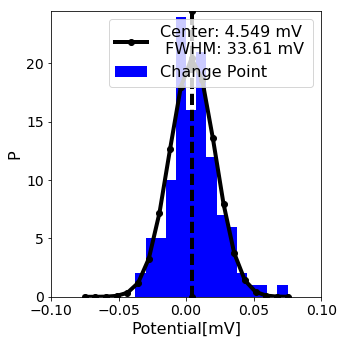

In [20]:
#MIDPOTENTIAL HISTGRAM FITTING/ PLOTTING
fig, axes = subplots(figsize=(5, 5))
# plt.figure()
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.size"] = "14"
min_range = -0.075
max_range = 0.075
range_fit = [min_range, max_range]
bins = 20
bin_centers_on = linspace(range_fit[0], range_fit[1], bins)
x=linspace(range_fit[0], range_fit[1], 100)# for a smooth fitting plot include more points

from scipy.interpolate import interp1d
from lmfit.models import GaussianModel
mod = GaussianModel()
# params = gmodel.make_params(center=0.01, amplitude=10, sigma=0.02)
#Change point--------------------------
n,bins_on1,patches = axes.hist(E0_array['E0_fit'], bins = bins, range=range_fit, color='b', label='Change Point')#E0_list from running all folder
y=n; x=bin_centers_on;
result1 = mod.fit(y, center=0.01, amplitude=10, sigma=0.02, x=x)
temp =result1.best_values
FWHM = 2*temp['sigma']*1000 #V
cent = temp['center']*1000#eV
amp = temp['amplitude']

axes.plot(x, result1.best_fit, '-ko', lw=4, label='Center: %.3f mV \n FWHM: %.2f mV' %(cent, FWHM))
amp = temp['amplitude']
height = 0.3989423*amp/max(1.e-15, temp['sigma'])
axes.plot([cent*0.001, cent*0.001], [0, height+0.2*height], '--ok', lw=4)

axes.set_xlim(-0.1, 0.1)
axes.set_ylim(0,height+0.2*height)
axes.set_ylabel('P', fontsize=16)
axes.set_xlabel('Potential[mV]', fontsize=16)
axes.legend(fontsize=16)

fig.tight_layout()
# os.chdir(homedir)
# fig.savefig('/home/biswajit/Pictures/canters_temp/MidpointPotential_distribution.pdf', dpi=300, transparent=True)
# figure()
# result.plot()
os.chdir(parentdir)
savefig('FigPart_3b_E0_hist.pdf', dpi=300, transparent=True)

## Ton_Toff Histogram: Figure 4

In [40]:
1.5/101500

1.477832512315271e-05